# Art With a Message

In August of 2018, while walking around UCSD, I noticed a large, blinking light atop Urey Hall. Observing the flashes, it became clear quite quickly that it was blinking Morse Code. The question was, what did it say? Not being fluent in Morse, I captured the flashes the best I could with my phone in hopes of decoding the message offline.

The thought of watching a video over and over trying to decode dots and dashes from a signal lamp did not leave me terribly excited, so I decided to try doing it programmatically. Some thresholding, a little Forier Analysis, filtering, and a Morse Code tree should tease out the message from the video. Overall, a great project for learning some OpenCV. Sadly, my shaky cell phone video was not conducive to being easily analysed, so I vowed to return with a tripod and a better camera for some solid video.

Unfortunately, the light disappeared after that. Until November, when it was mounted on a light pole between Urey Hall and Mayer Hall, signalling proudly above campus. I got as high and as close as I could and still have a view of the light -- the top level of the molecular bridge between Bonner and Mayer Halls -- and set up my tripod and camera with my largest lens to record around 10 minutes of video. Since I was shooting with a "real" camera instead of my phone, I stopped down the aperture and quickened the shutter speed to get a nice, stable, contrasty video (exceptin' the bounce when I pressed the record button).

When I got to my computer, I shrunk the video down to a more managable, yet viewable size, and stripped the audio. It looked like this, only the lights blinked:

![morse tower movie](20181110-thumbnail.png)

I actually made a grayscale version of the video, because it's easier to play with (only one set of magnitudes to deal with instead of three). Video conversions were done with ffmpeg, because ffmpeg is awesome.

With some usable video captured, the first thing to do was to make an OpenCV environment in Anaconda so I could play around in a Jupyter Notebook. On Linux, that's simple enough, since OpenCV is included.

```
$ conda create --name opencv
$ source activate opencv
$ conda install -n opencv opencv matplotlib
$ jupyter notebook
```

Once we created a notebook to play in (this very one!), we could import our libraries, and switch to present tense in our narrative.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
cv2.__version__

'3.4.2'

## Getting Our Feet Wet

First thing first, we need to be able to read our video. According to the 
[OpenCV Python Video tutorial](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_video_display/py_video_display.html),
that's just a matter of calling `cv2.VideoCapture()` with the path to the file as an argument. As long as `cap.isOpened()` is `True`, we are playing with video data.

In [3]:
video = '20181110-854x480-gray.mov'
cap = cv2.VideoCapture(video)
cap.isOpened()

True

In [4]:
ret, frame = cap.read()
ret, type(frame)

(True, numpy.ndarray)

So the frame is an ndarray. At this point, we're essentially playing in numpy. So much for learning much OpenCV.

In [5]:
cap.release()

## Analysing the Data

Our first attack is going to be a simple threshold on the max value of the video frame. To make things even easier on us, we can crop the video so it only contains the highest contrast part. Specifically, the contents of the red box in this image:

![Crop area](20181110-crop.png)

Using our favorite image editing program, we know that the coordinates of the upper left corner of that box is at 440, 190, and it's 15 pixels wide and 60 pixels tall. Exactly the information ffmpeg needs to crop the video for us.

```$ ffmpeg -i 20181110-854x4800-gray.mov -vf crop=15:60:440:190 20181110-crop.mov```

In [6]:
def frame_maxes(fname):
    """ Generate the max values in each frame of the video file `fname`"""
    cap = cv2.VideoCapture(fname)
    while True:
        ret, frame = cap.read()
        if ret:
            yield np.max(frame)
        else:
            break
            
    cap.release()
        
# Max values as an ndarray.        
video = '20181110-crop.mov'
fmax = np.array([m for m in frame_maxes(video)], dtype=int)

In [7]:
%matplotlib inline

Text(0,0.5,'Max pixel value')

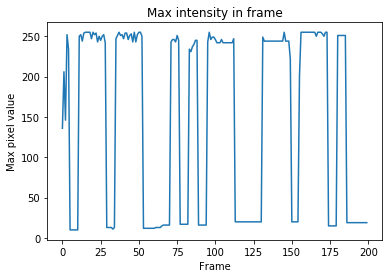

In [8]:
fig = plt.figure()
width=200
ax = fig.add_subplot(111)
ax.plot(np.arange(width), fmax[:width])
ax.set_title('Max intensity in frame')
ax.set_xlabel('Frame')
ax.set_ylabel('Max pixel value')

This looks very promising. Looks like we can threshold the max values to determine our on/off points.

In [9]:
threshold = 125
signal = fmax > threshold

Text(0,0.5,'Signal (high/low)')

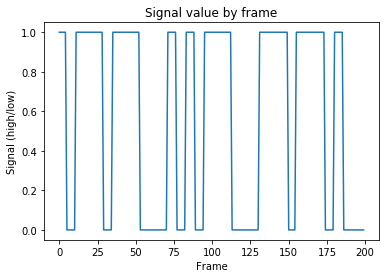

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(width), signal[:width])
ax.set_title('Signal value by frame')
ax.set_xlabel('Frame')
ax.set_ylabel('Signal (high/low)')

To turn this into Morse Code, we need to be able to distingush dots, dashes, letter breaks and word breaks. Each of those is determined by the length of a 'high' or 'low' run, and those runs are determined by the transition edges. So lets find the indexes of the transition edges, and see what our run lengths are.

In [11]:
signal = signal.astype(int)
edges = signal[1:] - signal[:-1]
edge_idx = np.where(edges != 0)[0]

In [12]:
def signal_runs(edges, edge_idx):
    """Returns number of frames each 'high' and 'low' run are."""
    runs = edge_idx - np.concatenate((np.array([0], dtype=int), edge_idx[:-1]))
    if edges[edge_idx[0]] > 0:
        # First transition was low to high.
        highs = runs[1::2]
        lows = runs[::2]
    else:
        # First transition was high to low.
        highs = runs[::2]
        lows = runs[1::2]
        
    return highs, lows

In [13]:
highs, lows = signal_runs(edges, edge_idx)

Text(0,0.5,'Count')

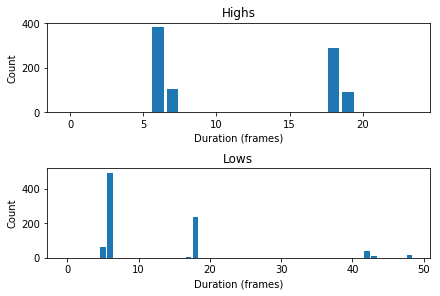

In [14]:
high_hist, high_edges = np.histogram(highs, bins=np.arange(highs.max() + 1))
low_hist, low_edges = np.histogram(lows, bins=np.arange(lows.max() + 1))
fig, ax = plt.subplots(2, 1, constrained_layout=True)
ax[0].bar(high_edges[:-1], high_hist)
ax[0].set_title('Highs')
ax[0].set_xlabel('Duration (frames)')
ax[0].set_ylabel('Count')
ax[1].bar(low_edges[:-1], low_hist)
ax[1].set_title('Lows')
ax[1].set_xlabel('Duration (frames)')
ax[1].set_ylabel('Count')

'High' run durations are mostly 6 or 18 frames in length, which makes sense since a 'dash' is supposed to be three times longer than a 'dot' in Morse Code. 'Low' run durations are mostly 6, 18, and 43 frames in length, corresponding to 'high' signal separations, symbol separations, and word separations respectively.

We have all the information we need. Now we need a function to decode it all.

## Decoding the Message

In [15]:
def morse_decode(edges, edge_idx, dot_dash_boundary, dash_space_boundary):
    """Decode Morse Code message in `edges` and `edge_idx`."""
    morse_lookup = {
        '.-': 'A',
        '-...': 'B',
        '-.-.': 'C',
        '-..': 'D',
        '.': 'E',
        '..-.': 'F',
        '--.': 'G',
        '....': 'H',
        '..': 'I',
        '.---': 'J',
        '-.-': 'K',
        '.-..': 'L',
        '--': 'M',
        '-.': 'N',
        '---': 'O',
        '.--.': 'P',
        '--.-': 'Q',
        '.-.': 'R',
        '...': 'S',
        '-': 'T',
        '..-': 'U',
        '...-': 'V',
        '.--': 'W',
        '-..-': 'X',
        '-.--': 'Y',
        '--..': 'Z',
        '.----': '1',
        '..---': '2',
        '...--': '3',
        '....-': '4',
        '.....': '5',
        '-....': '6',
        '--...': '7',
        '---..': '8',
        '----.': '9',
        '-----': '0'
    }
    
    message = []
    morse = []
    signal_high = edges[edge_idx[0]] < 0
    durations = edge_idx - np.concatenate((np.array([0], dtype=int), edge_idx[:-1]))

    for duration in durations.tolist():
        if signal_high:
            # `duration` is for a 'high' signal.
            morse.append('.' if duration < dot_dash_boundary else '-')
        else:
            # `duration` is for a 'low' signal.
            # We can ignore signal ('.'/'-') boundaries.
            if duration > dot_dash_boundary:
                # Symbol boundary. Decode.
                message.append(morse_lookup.get(''.join(morse), '?'))
                morse = []  # Reset signal aggregation.
                if duration > dash_space_boundary:
                    # Word boundary. Inject word break into message.
                    message.append(' ')
                    
        signal_high = not signal_high
            
    return ''.join(message)    

In [16]:
morse_decode(edges, edge_idx, 10, 30)

'WUGHT WHAT HATH GOD WROUGLT WHAT HATH GOD WROUGHT WHAT HATH GOD WROUGHT WHAT HATH GOD WROUGHT WHAT HATH GOD WROUGHT WHAT HATH GOD WROUGHT WHAT HATH GOD WROUGHT EMHAT HATH GOD WROUGHT WHAT HATH GOD WROUGHT WHAT HATH GOD WROUGHT WHAT HATH GOD WROUGHT WHAT HATH GOD WROUGHT WHAT HATH GOD WROUGHT WHAT HATH GOD WROUGHT WHAT HATH GOD WROUGHT WHAT HATH GOD WROUGHT WHAT HATH GOD WROUGHT WH'

["What hath god wrought"](https://en.wikipedia.org/wiki/Baltimore%E2%80%93Washington_telegraph_line), an appropriate first message for a Morse signalling lamp. No doubt UCSD will change the message occasionally.

